<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Fraude_CB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Détection de fraudes à la carte bancaire

Cette base de données contient des transactions effectuées par CB en septembre 2013 par des utilisateurs européens. Les données ont été enregistrées sur deux jours, pendant lesquels 492 utilisations frauduleuses sur un total de 284 807 transactions ont été enregistrées.  

Ce ratio est fortement déséquilibré car les cas de fraudes ne représentent que 0.172% des transactions. Un apprentissage supervisé n'est donc pas possible ici.  

Nous allons utiliser un auto-encodeur pour effectuer un apprentissage non supervisé afin de détecter des irrégularités dans les données, indices de fraudes.  

Les données sont disponibles sur le site de [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

## Lecture des données

Le nombre de données est très grand. Pour réduire le temps de calcul, nous n'utiliserons qu'une partie d'entre elles.  

In [2]:
!wget -q "https://github.com/AlexandreBourrieau/ML-F1/raw/master/Carnets%20Jupyter/Donn%C3%A9es/creditcard.zip"
!unzip creditcard.zip -x

Archive:  creditcard.zip
  inflating: creditcard.csv          


In [3]:
!ls

creditcard.csv	creditcard.zip	sample_data


In [4]:
data = pd.read_csv("creditcard.csv")
data = data.head(30000)
data.shape

(30000, 31)

Les colonnes qui ne sont pas anonymisées sont :
- Time : Temps écoulé depuis la première transaction
- Amount : Montant de la transaction
- Class : 0 = Achat non frauduleux / 1 = achat frauduleux
  
Les autres données anonymes sont par exemple les coordonnées de l'acheteur, son adresse, ...

In [5]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Regardons combien nous avons de données frauduleuses :

In [6]:
data.groupby(['Class']).count()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906,29906
1,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94


In [7]:
100*(94/29906)

0.31431819701732094

## Préparation des données

La colonne Time est ignorée et le montant de la transaction est normalisé. Les autres colonnes sont inchangées

In [8]:
data = data.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [9]:
x_entrainement, x_test = train_test_split(data, test_size=0.2, random_state=0)
x_entrainement = x_entrainement.drop(['Class'], axis=1)
y_test = x_test['Class']
x_test = x_test.drop(['Class'], axis=1)
x_entrainement = x_entrainement.values
x_test = x_test.values
x_entrainement.shape

(24000, 29)

## Modèle de l'Auto-encodeur

Ce modèle est un modèle standard d'auto-encodeur à quatre couches.

In [54]:
dimension_entrees = x_entrainement.shape[1]
dimension_encodeur = 14

model = Sequential()
model.add(Dense(dimension_encodeur, activation="tanh", input_shape=(dimension_entrees,)))
model.add(Dense(int(dimension_encodeur /2), activation="relu"))
model.add(Dense(int(dimension_encodeur /2), activation='tanh'))
model.add(Dense(dimension_entrees, activation='relu'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 34)                1020      
_________________________________________________________________
dense_33 (Dense)             (None, 17)                595       
_________________________________________________________________
dense_34 (Dense)             (None, 17)                306       
_________________________________________________________________
dense_35 (Dense)             (None, 29)                522       
Total params: 2,443
Trainable params: 2,443
Non-trainable params: 0
_________________________________________________________________


# Model Training

Given such a simple model and relatively small data set, it might be faster to train without a GPU.

In [55]:
nb_epoch = 40
batch_size = 35

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])

history = model.fit(x_entrainement, x_entrainement,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    validation_data=(x_test, x_test),
                    verbose=1)

autoencoder = model

Epoch 1/40
4800/4800 [==============================] - 9s 2ms/step - loss: 1.0596 - acc: 0.5416 - val_loss: 0.7724 - val_acc: 0.7613
Epoch 2/40
4800/4800 [==============================] - 8s 2ms/step - loss: 0.7718 - acc: 0.7797 - val_loss: 0.7313 - val_acc: 0.7977
Epoch 3/40
4800/4800 [==============================] - 8s 2ms/step - loss: 0.7934 - acc: 0.8162 - val_loss: 0.7091 - val_acc: 0.8388
Epoch 4/40
4800/4800 [==============================] - 8s 2ms/step - loss: 0.7930 - acc: 0.8216 - val_loss: 0.7001 - val_acc: 0.8338
Epoch 5/40
4800/4800 [==============================] - 8s 2ms/step - loss: 0.7344 - acc: 0.8355 - val_loss: 0.6972 - val_acc: 0.8413
Epoch 6/40
4800/4800 [==============================] - 8s 2ms/step - loss: 0.7302 - acc: 0.8438 - val_loss: 0.6946 - val_acc: 0.8505
Epoch 7/40
4800/4800 [==============================] - 8s 2ms/step - loss: 0.7665 - acc: 0.8469 - val_loss: 0.6880 - val_acc: 0.8640
Epoch 8/40
4800/4800 [==============================] - 8s 2ms

## Model Performance

A simple plot of model accuracy to confirm that it is learning something.

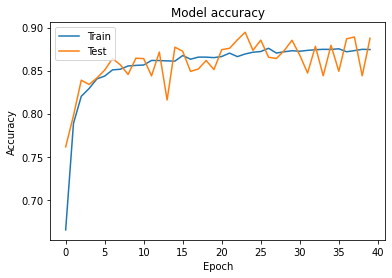

In [56]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Prediction

Predictions are made on the test set. The mean-squared error (MSE) is calculated between the test set and their predictions. If the MSE is high, it's a potential irregularity that might suggest fraud. It's not perfect, there will be false positives and false negatives.

In [57]:
predictions = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})

In [22]:
error_df.head()

,reconstruction_error,true_class
8225,0.290409,0
10794,0.761553,0
9163,0.288454,0
26591,0.120735,0
6631,0.330194,0


## Plot Reconstruction Error

The reconstruction error for each sample is plotted long with a color code indicating known fraud. Only 6000 samples are plotted, but the index is randomly sampled from the original set, so the X-axis shows almost the full range of indices.

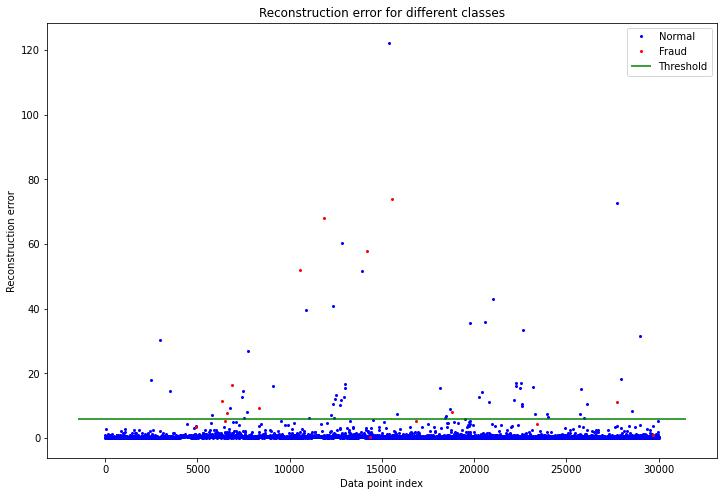

In [58]:
threshold = 6.0

groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(12, 8))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=2.0, linestyle='',
            label = "Fraud" if name == 1 else "Normal",
            color = "red" if name == 1 else "blue")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="green", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

# Analysis

Given the known fraud transactions, we can determine the number of true/false positives and negatives. Ideally, there should be no false positives and false negatives, but this is an imperfect model. Let's see how well it does.

In [59]:
normal = error_df[error_df.true_class == 0]
fraud = error_df[error_df.true_class == 1]

print('Normal transactions: %d, fraud transactions: %d' % (len(normal), len(fraud)))

Normal transactions: 5984, fraud transactions: 16


In [60]:
true_positives = len(fraud[fraud.reconstruction_error >= threshold])
false_positives = len(normal[normal.reconstruction_error >= threshold])

true_negatives = len(normal[normal.reconstruction_error < threshold])
false_negatives = len(fraud[fraud.reconstruction_error < threshold])

print('True positives: %d, true negatives: %d' % (true_positives, true_negatives))
print('False positives: %d, false negatives: %d' % (false_positives, false_negatives))

True positives: 10, true negatives: 5925
False positives: 59, false negatives: 6


## Confusion Matrix

The confusion matrix below shows the number of true/false positive/negatives. It's not perfect, but not too bad either.

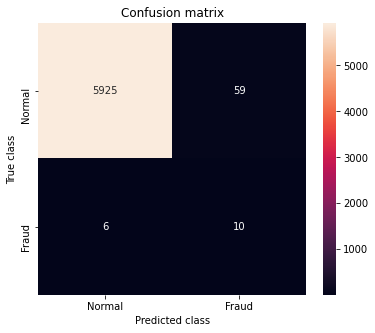

In [61]:
labels = ["Normal", "Fraud"]

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()